# 导入函数库

In [1]:
!rm -rf ta-lib
!rm -rf LightGBM

In [2]:
ENV_COLAB = 1
ENV_LOCAL = 2
ENV_JQ = 3

env_type = ENV_COLAB

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math, time, datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.feature_selection import SelectFromModel,SelectPercentile,f_classif #特征选择方法库
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, KFold
from sklearn.pipeline import Pipeline #导入Pipeline库
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, scale, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from xgboost.sklearn import XGBClassifier
import warnings
from tqdm.notebook import tqdm
from scipy.ndimage.interpolation import shift
import joblib
from pylab import mpl
import matplotlib
import os
import bottleneck as bn

if env_type == ENV_LOCAL:
    from jqdatasdk import *
    auth('', '')
elif env_type == ENV_COLAB:
    # 安装talib
    if not os.path.exists('/content/ta-lib'):
        os.chdir('/content/')
        !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
        !tar -xzvf ta-lib-0.4.0-src.tar.gz
        !cd ta-lib
        !./configure --prefix=/usr
        !make
        !make install
        !pip install Ta-Lib

    # 安装gpu版的lgb
    if not os.path.exists('/content/LightGBM'):
        os.chdir('/content/')
        !git clone --recursive --depth 1 --branch v3.1.1 https://github.com/Microsoft/LightGBM
        # ! git clone --recursive https://github.com/Microsoft/LightGBM
        !cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    

    # bayes_opt
    !pip3 install bayesian-optimization

    # google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    # 下载字体
    if not os.path.exists('/usr/share/fonts/truetype/SimHei.ttf'):
        # 下载--解压--移动字体文件
        !wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
        !unzip "simhei.zip"
        !rm "simhei.zip"
        !mv SimHei.ttf /usr/share/fonts/truetype/

    zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/SimHei.ttf')
    mpl.font_manager.fontManager.ttflist += mpl.font_manager.createFontList(['/usr/share/fonts/truetype/SimHei.ttf'])

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    plt.rcParams['axes.unicode_minus'] = False

    import seaborn as sns
    sns.set(font=zhfont.get_name())

    # 
    os.chdir('/content/')
    !cp '/content/gdrive/My Drive/Colab Notebooks/feature_selector.py' .
    !cp '/content/gdrive/My Drive/Colab Notebooks/feature_eng_v4.py' .

import lightgbm as lgb
from bayes_opt import BayesianOptimization
from feature_selector import *
from feature_eng_v4 import *

matplotlib.rcParams['font.family'] = 'SimHei'

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

--2021-01-20 06:43:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-20 06:43:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://netcologne.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-01-20 06:43:38--  https://netcologne.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netcologne

# 公共函数

In [4]:
#去除上市日期距beginDate不足n天的股票
def delete_deadline(stocks,beginDate,n):
    stockList = []
    beginDate = datetime.datetime.strptime(beginDate,"%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (beginDate-datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList

#去除ST类股票
def delete_ststock(stocks,begin_date):
    st_stock = get_extras('is_st',stocks,end_date=begin_date,count = 1)
    stockList = [stock for stock in stocks if not st_stock[stock][0]]
    return stockList

In [5]:
#获取特定时间的行业股票数据
def qry_indu_stocks(select_codes,date):
    industry_stocks = []
    for i in select_codes:
        temp = get_industry_stocks(i,date)
        industry_stocks.append(temp)
        
    industry_stocks = [i for j in industry_stocks for i in j]
    indu_stock_list = list(set(industry_stocks))
    indu_stock_list.sort(key=industry_stocks.index)
    
    return indu_stock_list

# 宏

In [6]:
# 回看区间，预测期间
look_back_period = 15
look_forward_period = 3

#设置样本区间
start_date = '2019-01-01'
end_date = '2021-01-15'

#训练集长度
train_percent = 0.8

if env_type == ENV_COLAB:
    security_list = ['000001.XSHE', '000002.XSHE', '000063.XSHE', '000066.XSHE', '000069.XSHE', '000100.XSHE', '000157.XSHE', '000166.XSHE', '000333.XSHE', '000338.XSHE', '000425.XSHE', '000538.XSHE', '000568.XSHE', '000596.XSHE', '000625.XSHE', '000627.XSHE', '000651.XSHE', '000656.XSHE', '000661.XSHE', '000671.XSHE', '000703.XSHE', '000708.XSHE', '000723.XSHE', '000725.XSHE', '000728.XSHE', '000768.XSHE', '000776.XSHE', '000783.XSHE', '000786.XSHE', '000858.XSHE', '000860.XSHE', '000876.XSHE', '000895.XSHE', '000938.XSHE', '000961.XSHE', '000963.XSHE', '000977.XSHE', '001979.XSHE', '002001.XSHE', '002007.XSHE', '002008.XSHE', '002024.XSHE', '002027.XSHE', '002032.XSHE', '002044.XSHE', '002049.XSHE', '002050.XSHE', '002120.XSHE', '002129.XSHE', '002142.XSHE', '002146.XSHE', '002153.XSHE', '002157.XSHE', '002179.XSHE', '002202.XSHE', '002230.XSHE', '002236.XSHE', '002241.XSHE', '002252.XSHE', '002271.XSHE', '002304.XSHE', '002311.XSHE', '002352.XSHE', '002371.XSHE', '002384.XSHE', '002410.XSHE', '002414.XSHE', '002415.XSHE', '002422.XSHE', '002456.XSHE', '002460.XSHE', '002463.XSHE', '002475.XSHE', '002493.XSHE', '002508.XSHE', '002555.XSHE', '002558.XSHE', '002594.XSHE', '002600.XSHE', '002601.XSHE', '002602.XSHE', '002607.XSHE', '002624.XSHE', '002673.XSHE', '002714.XSHE', '002736.XSHE', '002739.XSHE', '002773.XSHE', '002812.XSHE', '002821.XSHE', '002841.XSHE', '002916.XSHE', '002938.XSHE', '300003.XSHE', '300014.XSHE', '300015.XSHE', '300033.XSHE', '300059.XSHE', '300122.XSHE', '300124.XSHE', '300136.XSHE', '300142.XSHE', '300144.XSHE', '300347.XSHE', '300408.XSHE', '300413.XSHE', '300433.XSHE', '300498.XSHE', '300529.XSHE', '300601.XSHE', '300628.XSHE', '300676.XSHE', '600000.XSHG', '600004.XSHG', '600009.XSHG', '600010.XSHG', '600011.XSHG', '600015.XSHG', '600016.XSHG', '600018.XSHG', '600019.XSHG', '600025.XSHG', '600027.XSHG', '600028.XSHG', '600029.XSHG', '600030.XSHG', '600031.XSHG', '600036.XSHG', '600048.XSHG', '600050.XSHG', '600061.XSHG', '600066.XSHG', '600068.XSHG', '600085.XSHG', '600104.XSHG', '600109.XSHG', '600111.XSHG', '600115.XSHG', '600118.XSHG', '600161.XSHG', '600176.XSHG', '600177.XSHG', '600183.XSHG', '600196.XSHG', '600208.XSHG', '600233.XSHG', '600271.XSHG', '600276.XSHG', '600297.XSHG', '600299.XSHG', '600309.XSHG', '600332.XSHG', '600340.XSHG', '600346.XSHG', '600352.XSHG', '600362.XSHG', '600369.XSHG', '600383.XSHG', '600390.XSHG', '600406.XSHG', '600436.XSHG', '600438.XSHG', '600482.XSHG', '600487.XSHG', '600489.XSHG', '600498.XSHG', '600519.XSHG', '600522.XSHG', '600547.XSHG', '600570.XSHG', '600584.XSHG', '600585.XSHG', '600588.XSHG', '600600.XSHG', '600606.XSHG', '600637.XSHG', '600655.XSHG', '600660.XSHG', '600690.XSHG', '600703.XSHG', '600705.XSHG', '600741.XSHG', '600745.XSHG', '600760.XSHG', '600763.XSHG', '600795.XSHG', '600809.XSHG', '600837.XSHG', '600845.XSHG', '600848.XSHG', '600872.XSHG', '600886.XSHG', '600887.XSHG', '600893.XSHG', '600900.XSHG', '600919.XSHG', '600926.XSHG', '600958.XSHG', '600998.XSHG', '600999.XSHG', '601006.XSHG', '601009.XSHG', '601012.XSHG', '601021.XSHG', '601066.XSHG', '601088.XSHG', '601100.XSHG', '601108.XSHG', '601111.XSHG', '601117.XSHG', '601138.XSHG', '601155.XSHG', '601166.XSHG', '601169.XSHG', '601186.XSHG', '601198.XSHG', '601211.XSHG', '601216.XSHG', '601225.XSHG', '601229.XSHG', '601231.XSHG', '601238.XSHG', '601288.XSHG', '601318.XSHG', '601328.XSHG', '601336.XSHG', '601360.XSHG', '601377.XSHG', '601390.XSHG', '601398.XSHG', '601555.XSHG', '601577.XSHG', '601600.XSHG', '601601.XSHG', '601607.XSHG', '601618.XSHG', '601628.XSHG', '601633.XSHG', '601668.XSHG', '601669.XSHG', '601688.XSHG', '601727.XSHG', '601766.XSHG', '601788.XSHG', '601800.XSHG', '601808.XSHG', '601818.XSHG', '601838.XSHG', '601857.XSHG', '601872.XSHG', '601877.XSHG', '601878.XSHG', '601881.XSHG', '601888.XSHG', '601899.XSHG', '601901.XSHG', '601919.XSHG', '601933.XSHG', '601939.XSHG', '601985.XSHG', '601988.XSHG', '601989.XSHG', '601990.XSHG', '601998.XSHG', '603019.XSHG', '603156.XSHG', '603160.XSHG', '603259.XSHG', '603288.XSHG', '603369.XSHG', '603501.XSHG', '603658.XSHG', '603799.XSHG', '603833.XSHG', '603899.XSHG', '603986.XSHG', '603993.XSHG']
else:
    #聚宽一级行业
    industry_code = ['HY001', 'HY002', 'HY003', 'HY004', 'HY005', 'HY006', 'HY007', 'HY008', 'HY009', 'HY010', 'HY011']

    #聚宽二级行业(半导体设备、半导体产品、互联网零售、互联网软件与服务、投资银行业与经纪业、
    #环境与设施服务、医疗保健设备、医疗保健用品、医疗保健技术)
    selected_codes = ['HY523','HY524','HY466','HY510','HY501','HY432','HY485','HY486','HY578']

    #设定选取股票范围(精选行业、沪深300、中证500、中证全指、创业板指、创业300、多板块合并)
    stock_scope = ['industry','000300.XSHG','000905.XSHG','000985.XSHG','399006.XSHE','399012.XSHE','multiplate']

    #设定默认选取范围
    default_scope = stock_scope[1]

    #根据选择范围取数
    if default_scope == stock_scope[0]:
        stockList = qry_indu_stocks(selected_codes, start_date)
    elif default_scope == stock_scope[-1]:
        stockList = get_index_stocks(stock_scope[1]) 
        otherList = get_index_stocks(stock_scope[2]) 
        stockList.extend(otherList)#合并沪深300和中证500
        stockList = list(set(stockList))
    else:
        stockList = get_index_stocks(default_scope)#股票池设为沪深300成分股/中证500成分股/中证全指
        
    #过滤新股和ST股票
    security_list = delete_deadline(stockList, start_date, 90)
    security_list = delete_ststock(security_list, start_date)

print(security_list)

['000001.XSHE', '000002.XSHE', '000063.XSHE', '000066.XSHE', '000069.XSHE', '000100.XSHE', '000157.XSHE', '000166.XSHE', '000333.XSHE', '000338.XSHE', '000425.XSHE', '000538.XSHE', '000568.XSHE', '000596.XSHE', '000625.XSHE', '000627.XSHE', '000651.XSHE', '000656.XSHE', '000661.XSHE', '000671.XSHE', '000703.XSHE', '000708.XSHE', '000723.XSHE', '000725.XSHE', '000728.XSHE', '000768.XSHE', '000776.XSHE', '000783.XSHE', '000786.XSHE', '000858.XSHE', '000860.XSHE', '000876.XSHE', '000895.XSHE', '000938.XSHE', '000961.XSHE', '000963.XSHE', '000977.XSHE', '001979.XSHE', '002001.XSHE', '002007.XSHE', '002008.XSHE', '002024.XSHE', '002027.XSHE', '002032.XSHE', '002044.XSHE', '002049.XSHE', '002050.XSHE', '002120.XSHE', '002129.XSHE', '002142.XSHE', '002146.XSHE', '002153.XSHE', '002157.XSHE', '002179.XSHE', '002202.XSHE', '002230.XSHE', '002236.XSHE', '002241.XSHE', '002252.XSHE', '002271.XSHE', '002304.XSHE', '002311.XSHE', '002352.XSHE', '002371.XSHE', '002384.XSHE', '002410.XSHE', '002414.X

In [7]:
# 获取每次预测的时间（只需要考虑往后预测的时间片）
def get_period_date(peroid, start_date, end_date):
    stock_data = get_price('000300.XSHG', start_date, end_date, 'daily', fields=['close'])#根据指数取日期
    dates = [x.strftime('%Y-%m-%d') for x in list(stock_data.index)]
    dates = [dates[x] for x in range(0, len(dates), peroid)]

    return dates

if env_type == ENV_COLAB:
    date_list = ['2019-01-02', '2019-01-07', '2019-01-10', '2019-01-15', '2019-01-18', '2019-01-23', '2019-01-28', '2019-01-31', '2019-02-12', '2019-02-15', '2019-02-20', '2019-02-25', '2019-02-28', '2019-03-05', '2019-03-08', '2019-03-13', '2019-03-18', '2019-03-21', '2019-03-26', '2019-03-29', '2019-04-03', '2019-04-09', '2019-04-12', '2019-04-17', '2019-04-22', '2019-04-25', '2019-04-30', '2019-05-08', '2019-05-13', '2019-05-16', '2019-05-21', '2019-05-24', '2019-05-29', '2019-06-03', '2019-06-06', '2019-06-12', '2019-06-17', '2019-06-20', '2019-06-25', '2019-06-28', '2019-07-03', '2019-07-08', '2019-07-11', '2019-07-16', '2019-07-19', '2019-07-24', '2019-07-29', '2019-08-01', '2019-08-06', '2019-08-09', '2019-08-14', '2019-08-19', '2019-08-22', '2019-08-27', '2019-08-30', '2019-09-04', '2019-09-09', '2019-09-12', '2019-09-18', '2019-09-23', '2019-09-26', '2019-10-08', '2019-10-11', '2019-10-16', '2019-10-21', '2019-10-24', '2019-10-29', '2019-11-01', '2019-11-06', '2019-11-11', '2019-11-14', '2019-11-19', '2019-11-22', '2019-11-27', '2019-12-02', '2019-12-05', '2019-12-10', '2019-12-13', '2019-12-18', '2019-12-23', '2019-12-26', '2019-12-31', '2020-01-06', '2020-01-09', '2020-01-14', '2020-01-17', '2020-01-22', '2020-02-04', '2020-02-07', '2020-02-12', '2020-02-17', '2020-02-20', '2020-02-25', '2020-02-28', '2020-03-04', '2020-03-09', '2020-03-12', '2020-03-17', '2020-03-20', '2020-03-25', '2020-03-30', '2020-04-02', '2020-04-08', '2020-04-13', '2020-04-16', '2020-04-21', '2020-04-24', '2020-04-29', '2020-05-07', '2020-05-12', '2020-05-15', '2020-05-20', '2020-05-25', '2020-05-28', '2020-06-02', '2020-06-05', '2020-06-10', '2020-06-15', '2020-06-18', '2020-06-23', '2020-06-30', '2020-07-03', '2020-07-08', '2020-07-13', '2020-07-16', '2020-07-21', '2020-07-24', '2020-07-29', '2020-08-03', '2020-08-06', '2020-08-11', '2020-08-14', '2020-08-19', '2020-08-24', '2020-08-27', '2020-09-01', '2020-09-04', '2020-09-09', '2020-09-14', '2020-09-17', '2020-09-22', '2020-09-25', '2020-09-30', '2020-10-13', '2020-10-16', '2020-10-21', '2020-10-26', '2020-10-29', '2020-11-03', '2020-11-06', '2020-11-11', '2020-11-16', '2020-11-19', '2020-11-24', '2020-11-27', '2020-12-02', '2020-12-07', '2020-12-10', '2020-12-15', '2020-12-18', '2020-12-23', '2020-12-28', '2020-12-31', '2021-01-06', '2021-01-11', '2021-01-14']
else:
    date_list = get_period_date(look_forward_period, start_date, end_date)

print(date_list)

['2019-01-02', '2019-01-07', '2019-01-10', '2019-01-15', '2019-01-18', '2019-01-23', '2019-01-28', '2019-01-31', '2019-02-12', '2019-02-15', '2019-02-20', '2019-02-25', '2019-02-28', '2019-03-05', '2019-03-08', '2019-03-13', '2019-03-18', '2019-03-21', '2019-03-26', '2019-03-29', '2019-04-03', '2019-04-09', '2019-04-12', '2019-04-17', '2019-04-22', '2019-04-25', '2019-04-30', '2019-05-08', '2019-05-13', '2019-05-16', '2019-05-21', '2019-05-24', '2019-05-29', '2019-06-03', '2019-06-06', '2019-06-12', '2019-06-17', '2019-06-20', '2019-06-25', '2019-06-28', '2019-07-03', '2019-07-08', '2019-07-11', '2019-07-16', '2019-07-19', '2019-07-24', '2019-07-29', '2019-08-01', '2019-08-06', '2019-08-09', '2019-08-14', '2019-08-19', '2019-08-22', '2019-08-27', '2019-08-30', '2019-09-04', '2019-09-09', '2019-09-12', '2019-09-18', '2019-09-23', '2019-09-26', '2019-10-08', '2019-10-11', '2019-10-16', '2019-10-21', '2019-10-24', '2019-10-29', '2019-11-01', '2019-11-06', '2019-11-11', '2019-11-14', '2019

# 特征工程

## 构建数据集

In [8]:
if env_type == ENV_COLAB:
    df_factor_pre = joblib.load('/content/gdrive/MyDrive/return_A/feature_eng_v3.joblib')
else:
    df_factor_pre = get_factor_pre(security_list, date_list)

for date, df in df_factor_pre.items():
    df = df.replace([np.inf, -np.inf], np.nan)
    df_factor_pre[date] = df.dropna(axis=0)
    if df_factor_pre[date].empty:
        print(f'empty: {date}')
    
display(df_factor_pre[list(df_factor_pre.keys())[0]].head(10))

,pchg,收盘上涨天数/收盘下跌天数,股价高开天数/股价低开天数,开盘价振幅,收盘价振幅,当日收盘价与最高收盘价振幅,最高价振幅,最低价振幅,最高价与最低价振幅,每日最高价与最低价最大振幅,成交量上涨天数/成交量下跌天数,成交量振幅,成交金额上涨天数/成交金额下跌天数,成交金额振幅,倒数3日成交量之和/前面成交量之和,倒数3日成交量之和/成交量之和,倒数3日平均成交量/前面平均成交量,倒数3日平均成交量/平均成交量,换手率上涨天数/换手率下跌天数,换手率振幅,倒数3日换手率之和/前面换手率之和,倒数3日换手率之和/换手率之和,倒数3日平均换手率/前面平均换手率,倒数3日平均换手率/平均换手率,大阳线天数占比,大阴线天数占比,涨停天数占比,跌停天数占比,涨跌停板振幅,股价连续上涨最大天数占比,股价连续下跌最大天数占比,倒数3日收盘均价/前面收盘均价,倒数3日收盘均价/收盘均价,倒数最后一个交易日市值/第一个交易日市值,市值上涨天数/市值下跌天数,倒数3日平均市值/前面平均市值,倒数3日平均市值/平均市值,大单资金净流入天数/大单资金净流出天数,资金连续流入天数占比,资金连续流出天数占比,主力净流入占比之和,主力净流出占比之和,主力占比平均值,中单占比平均值,小单占比平均值,主力占流通市值,中单占流通市值,小单占流通市值,倒数3日主力平均值,倒数3日中单平均值,倒数3日小单平均值,倒数3日主力占流通市值,倒数3日中单占流通市值,倒数3日小单占流通市值,首个交易日开盘价牛逼10,首个交易日开盘价牛逼5,最后交易日收盘价牛逼10,形态:两只乌鸦,形态:三只乌鸦,形态:三内部上涨和下跌,形态:三线打击,形态:三外部上涨和下跌,形态:南方三星,形态:三个白兵,形态:弃婴,形态:大敌当前,形态:捉腰带线,形态:脱离,形态:收盘缺影线,形态:藏婴吞没,形态:反击线,形态:乌云压顶,形态:十字,形态:十字星,形态:蜻蜓十字/T形十字,形态:吞噬模式,形态:十字暮星,形态:暮星,形态:向上/下跳空并列阳线,形态:墓碑十字/倒T十字,形态:锤头,形态:上吊线,形态:母子线,形态:十字孕线,形态:风高浪大线,形态:陷阱,形态:修正陷阱,形态:家鸽,形态:三胞胎乌鸦,形态:颈内线,形态:倒锤头,形态:反冲形态,形态:由较长缺影线决定的反冲形态,形态:梯底,形态:长脚十字,形态:长蜡烛,形态:光头光脚/缺影线,形态:相同低价,形态:铺垫,形态:十字晨星,形态:晨星,形态:颈上线,形态:刺透形态,形态:黄包车夫,形态:上升/下降三法,形态:分离线,形态:射击之星,形态:短蜡烛,形态:纺锤,形态:停顿形态,形态:条形三明治,形态:探水竿,形态:跳空并列阴阳线,形态:插入,形态:三星,形态:奇特三河床,形态:向上跳空的两只乌鸦,形态:上升/下降跳空三法
000001.XSHE,1.100000,1.375000,1.111111,1.103896,1.113340,1.000000,1.112205,1.106168,1.142568,1.046784,1.111111,4.967706,1.111111,5.238640,0.219260,0.179831,1.242476,1.198871,1.111111,4.967233,0.219257,0.179828,1.242457,1.198856,0.00,0.0,0.00,0.0,1.074424,0.15,0.10,1.046246,1.039038,1.113171,1.375000,1.046400,1.039167,0.818182,0.10,0.15,86.0565,-72.3210,0.686775,-0.101615,-0.585175,0.005677,-0.000118,-0.005559,8545.489333,-3040.869067,-5504.620400,13.068566,-4.627862,-8.440704,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000002.XSHE,1.027724,0.900000,0.727273,1.125971,1.111879,0.994949,1.107067,1.090004,1.131977,1.045982,1.714286,4.821819,1.714286,5.233836,0.279473,0.218428,1.583678,1.456186,1.714286,4.820106,0.279476,0.218430,1.583697,1.456200,0.00,0.0,0.00,0.0,1.066323,0.15,0.15,1.028430,1.024063,1.106528,0.900000,1.028521,1.024140,0.818182,0.15,0.20,55.8207,-91.1061,-1.764270,0.346850,1.417415,-0.013818,0.002589,0.011229,-677.197333,-157.831467,835.029333,-0.872199,-0.121097,0.993297,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000063.XSHE,1.263092,0.900000,1.375000,1.237538,1.224375,0.994169,1.239359,1.200818,1.264691,1.106046,0.900000,5.612061,0.900000,6.339738,0.242095,0.194908,1.371869,1.299389,0.900000,5.612318,0.242095,0.194909,1.371873,1.299392,0.10,0.0,0.00,0.0,1.121899,0.25,0.25,1.156361,1.129861,1.199400,0.900000,1.156430,1.129917,0.428571,0.15,0.35,69.6356,-131.9863,-3.117535,0.005525,3.112030,-0.088193,0.000565,0.087629,-11477.031467,1256.598400,10220.434667,-41.774912,4.592908,37.182011,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000066.XSHE,1.144904,1.375000,0.583333,1.250505,1.263581,1.000000,1.278000,1.253579,1.306748,1.079457,1.375000,3.044576,1.111111,3.244925,0.283024,0.220591,1.603801,1.470608,1.375000,3.044613,0.283022,0.220590,1.603792,1.470602,0.10,0.0,0.00,0.0,1.083235,0.20,0.10,1.150984,1.125494,1.262426,1.375000,1.151032,1.125533,1.500000,0.20,0.10,113.6620,-67.2547,2.320365,-0.876120,-1.444235,0.301469,-0.114327,-0.187141,1806.760367,-1105.226633,-701.533767,34.896166,-21.274617,-13.621549,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## 数据预处理

In [9]:
#数据预处理函数
def data_preprocessing(factor_data, date):
    #中位数去极值
    factor_data = winsorize_med(factor_data, scale=5, inf2nan=True,axis=0)
    #中性化处理
    factor_data = neutralize(factor_data, date=date, axis=0)
    #标准化处理
    factor_data = standardlize(factor_data,inf2nan=True,axis=0)
    return factor_data

In [10]:
date_list = list(df_factor_pre.keys())
date_list.sort()

#预处理后的因子训练集
df_factor = {}

#最终因子值数据表
for date in tqdm(date_list):
    df_factor[date] = data_preprocessing(df_factor_pre[date], date)
    # df_factor[date].dropna(axis=1, inplace=True)

In [ ]:
# 统计pchg每个分段的统计
pchgs = []
for date, factor in df_factor.items():
    pchgs += list(factor['pchg'].values)

pchgs.sort(reverse=True)
# print(pchgs)

In [16]:
pchgs = np.array(pchgs)

In [26]:
print(f'> 1.05 比例: {len(pchgs[pchgs > 1.05]) / len(pchgs)}')
print(f'> 1.0 & < 1.05 比例: {len(pchgs[(pchgs > 1.0) & (pchgs < 1.05)]) / len(pchgs)}')
print(f'> 0.95 & < 1.0 比例: {len(pchgs[(pchgs > 0.95) & (pchgs < 1.0)]) / len(pchgs)}')
print(f'< 0.95 比例: {len(pchgs[pchgs < 0.95]) / len(pchgs)}')

> 1.05 比例: 0.1264461895807986
> 1.0 & < 1.05 比例: 0.38555469527707115
> 0.95 & < 1.0 比例: 0.39650481141466654
< 0.95 比例: 0.07687202743059396


In [ ]:
def calc_label(names, name):
    offset = names.index(name) / len(names)
    if offset < 0.30:
        return 0
    if offset > 0.70:
        return 2
    return 1

In [ ]:
#准备训练集+验证集数据
train_data = pd.DataFrame()

for date in tqdm(date_list[: int(len(date_list) * train_percent)]):
    traindf = df_factor[date]
    
    #取每只股票收益率数据
    traindf = traindf.sort_values(by=['pchg'], ascending=False)    
    traindf = traindf.dropna() 
    names = list(traindf.index)
    traindf['label'] = traindf.apply(lambda x: calc_label(names, x.name), axis=1)

    if train_data.empty:
        train_data = traindf
    else:
        train_data = train_data.append(traindf)
       
X_train_df = train_data.copy()
y_train = train_data['label'].values
del X_train_df['pchg']
del X_train_df['label']

print(X_train_df.shape)
print(y_train.shape)


(36132, 117)
(36132,)


In [ ]:
#准备测试集数据        
test_data_dict = {}
X_test_dict = {}
y_test_dict = {}

for date in tqdm(date_list[int(len(date_list) * train_percent) : -1]):
    testdf = df_factor[date]
    
    #取每只股票收益率数据
    testdf = testdf.sort_values(by=['pchg'], ascending=False)
    testdf = testdf.dropna()
    if testdf.empty:
        print(f'empty: {date}')

    names = list(testdf.index)
    testdf['label'] = testdf.apply(lambda x: calc_label(names, x.name), axis=1)
    
    test_data_dict[date] = testdf

    X_test_df = testdf.copy()
    y_test = testdf['label'].values
    del X_test_df['pchg']
    del X_test_df['label']

    X_test_dict[date] = X_test_df
    y_test_dict[date] = y_test
    
print(X_test_dict.keys())


dict_keys(['2020-08-19', '2020-08-24', '2020-08-27', '2020-09-01', '2020-09-04', '2020-09-09', '2020-09-14', '2020-09-17', '2020-09-22', '2020-09-25', '2020-09-30', '2020-10-13', '2020-10-16', '2020-10-21', '2020-10-26', '2020-10-29', '2020-11-03', '2020-11-06', '2020-11-11', '2020-11-16', '2020-11-19', '2020-11-24', '2020-11-27', '2020-12-02', '2020-12-07', '2020-12-10', '2020-12-15', '2020-12-18', '2020-12-23', '2020-12-28', '2020-12-31', '2021-01-06'])


## 重要特征选择

In [ ]:
X_fs = train_data.drop(['pchg', 'label'], axis=1)

18 features with a correlation magnitude greater than 0.95.



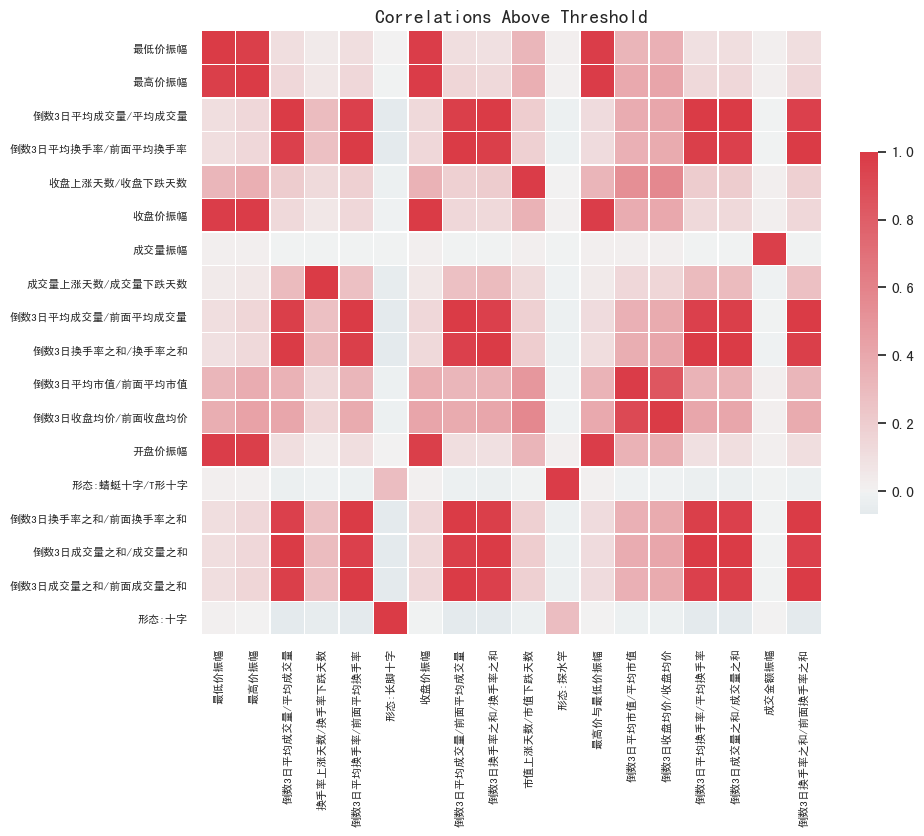

In [ ]:
matplotlib.rcParams['font.family'] = 'simhei'
# mpl.rc('font', family='simhei')
fs = FeatureSelector(data=X_fs, labels=y_train)
fs.identify_collinear(correlation_threshold=0.95)
fs.plot_collinear(plot_all=False)

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)), -1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

fs.identify_zero_importance(task='classification', eval_metric=evaluate_macroF1_lgb, n_iterations=50, early_stopping=True)
print('done')

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 1.06759	valid_0's macroF1: 0.375176
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's multi_logloss: 1.06262	valid_0's macroF1: 0.365646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 1.06112	valid_0's macroF1: 0.374358
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's multi_logloss: 1.06584	valid_0's macroF1: 0.362054
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 1.06472	valid_0's macroF1: 0.37225
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's multi_logloss: 1.06169	valid_0's macroF1

In [ ]:
fs.identify_low_importance(cumulative_importance=0.99)

63 features required for cumulative importance of 0.99 after one hot encoding.
54 features do not contribute to cumulative importance of 0.99.



In [ ]:
all_to_remove = fs.check_removal()
print(all_to_remove)
X_fs_removed = X_fs.drop(columns=all_to_remove)
X_fs_removed.drop_duplicates(keep=False, inplace=True)

Total of 62 features identified for removal
['最低价振幅', '形态:反击线', '形态:三胞胎乌鸦', '收盘价振幅', '形态:三线打击', '形态:弃婴', '形态:颈内线', '形态:向上跳空的两只乌鸦', '形态:两只乌鸦', '形态:三星', '市值上涨天数/市值下跌天数', '成交金额振幅', '形态:光头光脚/缺影线', '形态:乌云压顶', '形态:十字暮星', '最高价振幅', '形态:黄包车夫', '换手率上涨天数/换手率下跌天数', '倒数3日平均换手率/前面平均换手率', '形态:脱离', '形态:三只乌鸦', '形态:反冲形态', '倒数3日平均成交量/前面平均成交量', '形态:探水竿', '形态:奇特三河床', '形态:停顿形态', '形态:家鸽', '形态:十字孕线', '形态:十字星', '形态:射击之星', '形态:南方三星', '倒数3日换手率之和/前面换手率之和', '形态:由较长缺影线决定的反冲形态', '形态:向上/下跳空并列阳线', '倒数3日平均成交量/平均成交量', '形态:颈上线', '形态:长脚十字', '形态:墓碑十字/倒T十字', '形态:三个白兵', '倒数3日换手率之和/换手率之和', '形态:藏婴吞没', '形态:十字晨星', '形态:大敌当前', '形态:分离线', '形态:上吊线', '倒数3日收盘均价/收盘均价', '倒数3日平均换手率/平均换手率', '倒数3日成交量之和/成交量之和', '形态:条形三明治', '形态:刺透形态', '形态:梯底', '形态:修正陷阱', '形态:上升/下降三法', '形态:锤头', '最高价与最低价振幅', '形态:相同低价', '倒数3日平均市值/平均市值', '形态:铺垫', '形态:三内部上涨和下跌', '形态:蜻蜓十字/T形十字', '形态:晨星', '形态:上升/下降跳空三法']


In [ ]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,收盘价振幅,开盘价振幅,0.971801
1,最高价振幅,开盘价振幅,0.974907
2,最高价振幅,收盘价振幅,0.984225
3,最低价振幅,开盘价振幅,0.981915
4,最低价振幅,收盘价振幅,0.975514


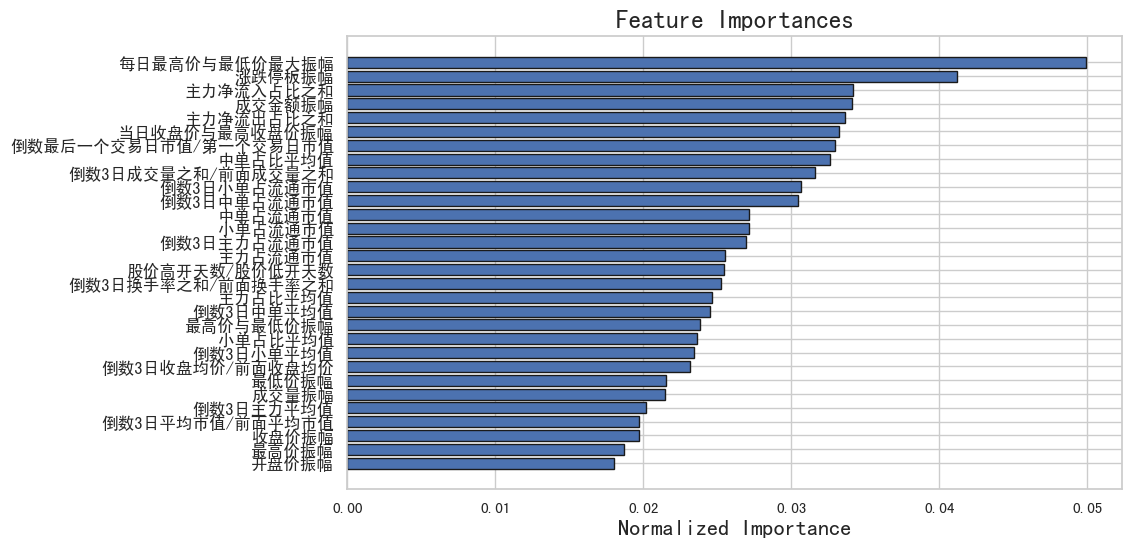

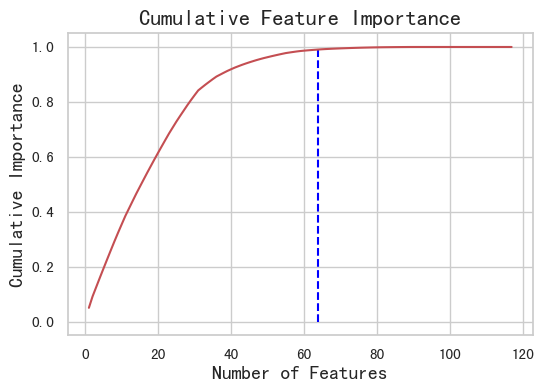

64 features required for 0.99 of cumulative importance


In [ ]:
matplotlib.rcParams['font.family'] = 'SimHei'
fs.plot_feature_importances(threshold=0.99, plot_n=30)

In [ ]:
X_fs_removed = fs.remove(methods = 'all')
filter_columns = list(X_fs_removed.columns)
display(filter_columns)
display(X_fs_removed.head(20))

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 62 features.


['收盘上涨天数/收盘下跌天数',
 '股价高开天数/股价低开天数',
 '开盘价振幅',
 '当日收盘价与最高收盘价振幅',
 '每日最高价与最低价最大振幅',
 '成交量上涨天数/成交量下跌天数',
 '成交量振幅',
 '成交金额上涨天数/成交金额下跌天数',
 '倒数3日成交量之和/前面成交量之和',
 '换手率振幅',
 '大阳线天数占比',
 '大阴线天数占比',
 '涨停天数占比',
 '跌停天数占比',
 '涨跌停板振幅',
 '股价连续上涨最大天数占比',
 '股价连续下跌最大天数占比',
 '倒数3日收盘均价/前面收盘均价',
 '倒数最后一个交易日市值/第一个交易日市值',
 '倒数3日平均市值/前面平均市值',
 '大单资金净流入天数/大单资金净流出天数',
 '资金连续流入天数占比',
 '资金连续流出天数占比',
 '主力净流入占比之和',
 '主力净流出占比之和',
 '主力占比平均值',
 '中单占比平均值',
 '小单占比平均值',
 '主力占流通市值',
 '中单占流通市值',
 '小单占流通市值',
 '倒数3日主力平均值',
 '倒数3日中单平均值',
 '倒数3日小单平均值',
 '倒数3日主力占流通市值',
 '倒数3日中单占流通市值',
 '倒数3日小单占流通市值',
 '首个交易日开盘价牛逼10',
 '首个交易日开盘价牛逼5',
 '最后交易日收盘价牛逼10',
 '形态:三外部上涨和下跌',
 '形态:捉腰带线',
 '形态:收盘缺影线',
 '形态:十字',
 '形态:吞噬模式',
 '形态:暮星',
 '形态:母子线',
 '形态:风高浪大线',
 '形态:陷阱',
 '形态:倒锤头',
 '形态:长蜡烛',
 '形态:短蜡烛',
 '形态:纺锤',
 '形态:跳空并列阴阳线',
 '形态:插入']

,收盘上涨天数/收盘下跌天数,股价高开天数/股价低开天数,开盘价振幅,当日收盘价与最高收盘价振幅,每日最高价与最低价最大振幅,成交量上涨天数/成交量下跌天数,成交量振幅,成交金额上涨天数/成交金额下跌天数,倒数3日成交量之和/前面成交量之和,换手率振幅,大阳线天数占比,大阴线天数占比,涨停天数占比,跌停天数占比,涨跌停板振幅,股价连续上涨最大天数占比,股价连续下跌最大天数占比,倒数3日收盘均价/前面收盘均价,倒数最后一个交易日市值/第一个交易日市值,倒数3日平均市值/前面平均市值,大单资金净流入天数/大单资金净流出天数,资金连续流入天数占比,资金连续流出天数占比,主力净流入占比之和,主力净流出占比之和,主力占比平均值,中单占比平均值,小单占比平均值,主力占流通市值,中单占流通市值,小单占流通市值,倒数3日主力平均值,倒数3日中单平均值,倒数3日小单平均值,倒数3日主力占流通市值,倒数3日中单占流通市值,倒数3日小单占流通市值,首个交易日开盘价牛逼10,首个交易日开盘价牛逼5,最后交易日收盘价牛逼10,形态:三外部上涨和下跌,形态:捉腰带线,形态:收盘缺影线,形态:十字,形态:吞噬模式,形态:暮星,形态:母子线,形态:风高浪大线,形态:陷阱,形态:倒锤头,形态:长蜡烛,形态:短蜡烛,形态:纺锤,形态:跳空并列阴阳线,形态:插入
601901.XSHG,0.900000,0.357143,1.124498,0.937833,1.049020,0.583333,3.884983,0.583333,0.243169,3.887417,0.0,0.00,0.0,0.00,1.066981,0.15,0.15,0.992078,0.936396,0.991777,0.428571,0.10,0.30,20.9085,-134.8613,-5.697640,1.706940,3.990705,-0.262764,0.079404,0.183360,203.360567,-89.014533,-114.346000,1.393284,-0.611890,-0.781394,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002230.XSHE,1.111111,0.583333,1.091342,0.989666,1.050903,0.900000,5.145772,0.900000,0.285309,5.146020,0.0,0.00,0.0,0.00,1.049649,0.30,0.20,1.015419,0.989723,1.015379,0.818182,0.20,0.25,49.3017,-105.4690,-2.808365,-0.214790,3.023150,-0.127133,-0.009955,0.137088,6785.938767,-2919.980767,-3865.958033,45.244419,-19.451588,-25.792831,1.0,1.0,1.0,0.0,100.0,0.0,0.0,100.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0
601066.XSHG,0.583333,0.500000,1.248521,0.809747,1.107961,0.727273,2.892764,0.727273,0.138404,2.892766,0.0,0.05,0.0,0.05,1.135422,0.10,0.25,0.850648,0.809217,0.850490,0.333333,0.05,0.30,12.1041,-103.0804,-4.548815,0.521925,4.026895,-2.367188,0.309696,2.057495,-845.066667,122.298267,722.768433,-74.422270,11.419530,63.002743,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0
600369.XSHG,0.727273,0.583333,1.146707,0.888889,1.054545,0.900000,2.081729,0.900000,0.184860,2.081883,0.0,0.00,0.0,0.00,1.057057,0.15,0.25,0.928318,0.889169,0.928407,0.666667,0.15,0.25,33.8235,-78.8073,-2.249190,-0.937470,3.186660,-0.224334,-0.082508,0.306842,-108.356933,61.052400,47.304533,-1.730408,1.000106,0.730302,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
601377.XSHG,0.461538,0.500000,1.147982,0.849711,1.054299,0.900000,2.848866,0.900000,0.210809,2.848505,0.0,0.00,0.0,0.00,1.055549,0.10,0.25,0.925409,0.850379,0.925515,0.428571,0.10,0.30,28.5608,-147.6693,-5.955425,1.700955,4.254475,-0.366927,0.104492,0.262435,-268.635233,-252.984867,521.620067,-2.727112,-2.443391,5.170503,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-200.0,0.0,0.0,0.0,0.0,0.0,0.0
601990.XSHG,0.583333,0.500000,1.113960,0.911765,1.065808,0.583333,2.673999,0.583333,0.150272,2.673993,0.0,0.00,0.0,0.00,1.070665,0.15,0.25,0.936606,0.911765,0.936559,0.333333,0.05,0.25,20.0348,-87.6870,-3.382610,-1.404595,4.787195,-2.713454,-1.095925,3.809371,49.437133,-104.696767,55.259600,5.837676,-12.967022,7.129342,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0
600061.XSHG,0.583333,0.800000,1.218713,0.819300,1.067308,1.111111,2.283580,0.727273,0.234536,2.283286,0.0,0.00,0.0,0.00,1.094507,0.10,0.20,0.905218,0.819535,0.905202,0.176471,0.05,0.50,19.6708,-102.7512,-4.154020,-0.173940,4.327950,-0.211449,-0.009627,0.221075,220.734933,-390.326000,169.591100,1.720400,-3.175925,1.455526,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0
601878.XSHG,0.461538,0.583333,1.182081,0.845324,1.059680,0.900000,3.241714,0.900000,0.127064,3.241717,0.0,0.00,0.0,0.00,1.069363,0.15,0.25,0.909460,0.845519,0.909413,0.333333,0.10,0.30,19.4308,-102.2599,-4.141455,0.045800,4.095655,-0.896044,0.020580,0.875464,-220.975733,-5.785500,226.761200,-8.142566,0.016185,8.126380,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0
601555.XSHG,1.111111,0.727273,1.115000,0.919643,1.052721,0.900000,1.997104,0.900000,0.165270,1.997458,0.0,0.00,0.0,0.00,1.060665,0.15,0.15,0.960283,0.919619,0.960387,0.818182,0.15,0.15,40.5253,-61.6683,-1.057150,0.618285,0.4388

## 显著特征比例

In [ ]:
# 使用f_classif方法选择特征最明显的?%数量的特征
transform = SelectPercentile(f_classif)  
model = lgb.LGBMClassifier(n_estimators=800, verbose=1, objective='multiclass', num_class=3)

# 建立由特征选择和分类模型构成的“管道”对象
model_pipe = Pipeline(steps=[('anova', transform), ('model', model)]) 

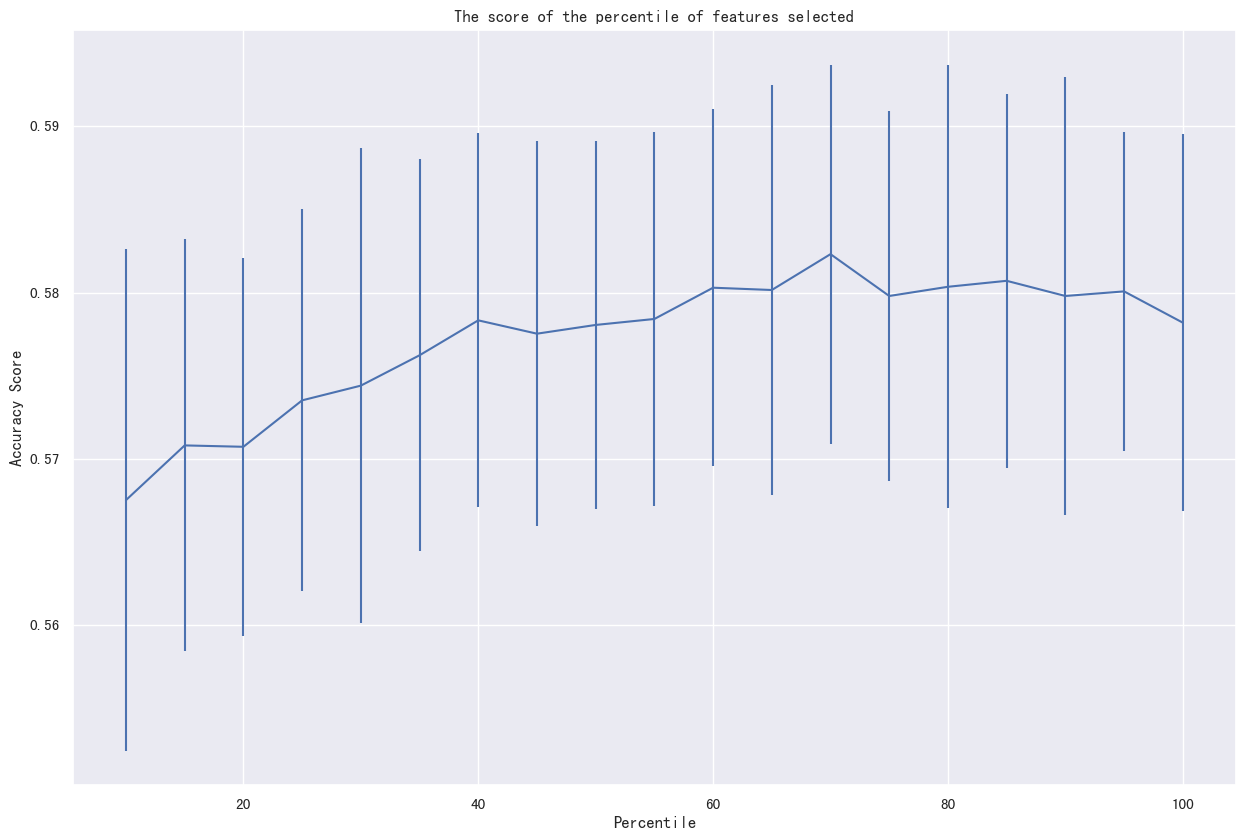

In [ ]:
# 选择最佳特征比例
score_stds = list()
score_means = list()
percentiles = (10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100)

for percentile in tqdm(percentiles):
    model_pipe.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(model_pipe, X_fs_removed, y_train, cv=7, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
    
plt.figure(figsize=(15, 10))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('The score of the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

In [ ]:
#使用f_classif方法选择特征最明显的?%数量的特征
transform = SelectPercentile(f_classif, percentile=70)  
model = lgb.LGBMClassifier(n_estimators=800, verbose=1, objective='multiclass', num_class=3)

# 建立由特征选择和分类模型构成的“管道”对象
model_pipe = Pipeline(steps=[('anova', transform), ('model', model)])  

transform.fit(X_fs_removed, y_train)  # 应用特征选择对象选择要参与建模的特征变量

train_minus_target = X_fs_removed # train_data.drop(['pchg', 'label'], axis=1)
columns = np.asarray(train_minus_target.columns.values)
support = np.asarray(transform.get_support())
columns_with_support = columns[support]

display(columns_with_support)
display(len(columns_with_support))

array(['收盘上涨天数/收盘下跌天数', '股价高开天数/股价低开天数', '开盘价振幅', '收盘价振幅',
       '每日最高价与最低价最大振幅', '成交量上涨天数/成交量下跌天数', '成交金额上涨天数/成交金额下跌天数',
       '倒数3日成交量之和/前面成交量之和', '换手率振幅', '大阳线天数占比', '大阴线天数占比', '涨停天数占比',
       '跌停天数占比', '涨跌停板振幅', '股价连续上涨最大天数占比', '股价连续下跌最大天数占比',
       '倒数3日收盘均价/前面收盘均价', '倒数最后一个交易日市值/第一个交易日市值', '倒数3日平均市值/前面平均市值',
       '大单资金净流入天数/大单资金净流出天数', '资金连续流入天数占比', '资金连续流出天数占比', '主力净流入占比之和',
       '主力净流出占比之和', '主力占比平均值', '中单占比平均值', '小单占比平均值', '中单占流通市值', '小单占流通市值',
       '倒数3日主力平均值', '倒数3日中单平均值', '倒数3日小单平均值', '倒数3日主力占流通市值',
       '倒数3日中单占流通市值', '倒数3日小单占流通市值', '首个交易日开盘价牛逼10', '最后交易日收盘价牛逼10',
       '形态:捉腰带线', '形态:收盘缺影线', '形态:长蜡烛'], dtype=object)

40

## 数据标准化/归一化

In [ ]:
use_transform = False
use_scale = True

def get_X_train(scale=True):
    X_train_final = None
    if use_transform:
        X_train_final = transform.transform(X_fs_removed)
    else:
        X_train_final =  X_fs_removed.values

    if scale and use_scale:
        X_train_final = global_scaler.transform(X_train_final)

    return X_train_final

def get_X_test(date, scale=True):
    X_test = X_test_dict[date]
    X_test = X_test[list(X_fs_removed.columns)]

    X_test_final = None
    if use_transform:
        X_test_final = transform.transform(X_test)
    else:
        X_test_final =  X_test.values

    if scale and use_scale:
        X_test_final = global_scaler.transform(X_test_final)

    return X_test_final

X_train_tmp = get_X_train(scale=False)
# global_scaler = RobustScaler()
global_scaler = MinMaxScaler()
# global_scaler = StandardScaler()
global_scaler.fit(X_train_tmp)

MinMaxScaler(copy=True, feature_range=(0, 1))

# 训练模型

## 随机森林(deprecated)

In [ ]:
transform.fit(X_train, y_train)  # 应用特征选择对象选择要参与建模的特征变量
X_train_final = transform.transform(X_train)  # 获得具有显著性特征的特征变量

In [ ]:
train_minus_target = train_data.drop(['pchg', 'label'], axis=1)
columns = np.asarray(train_minus_target.columns.values)
support = np.asarray(transform.get_support())
columns_with_support = columns[support]

display(columns_with_support)
display(len(columns_with_support))

array(['股价连续下跌最大天数', '市值下跌天数', '大单资金净流入天数', '大单资金净流出天数', '资金连续流入天数',
       '资金连续流出天数', '资金净流入大单占比', '资金净流出大单占比', '首个交易日开盘价牛逼10',
       '首个交易日开盘价牛逼5', '技术形态:吞噬模式'], dtype=object)

11

In [ ]:
X_train_final = X_fs_removed

In [ ]:
cv = StratifiedKFold(7)  # 设置交叉检验次数
#RandomForest n_estimators
parameters = [200, 300, 400, 500, 600]  # 设置模型参数列表
#RandomForest max_depth
#parameters = [10,20,30]
#RandomForest max_features
#parameters = [10,20,30]
#AdaBoost n_estimators
#parameters = [40,50,60]
#AdaBoost learning_rate
#parameters = [0.4,0.5,0.6]

score_methods = ['roc_auc','accuracy', 'precision', 'recall', 'f1']  # 设置交叉检验指标
#score_methods = ['roc_auc', 'f1']  # 设置交叉检验指标

for parameter in tqdm(parameters):  # 循环读出每个参数值
    t1 = time.time()  # 记录训练开始的时间
    score_list = list()  # 建立空列表用于存放不同交叉检验下各个评估指标的详细数据
    print ('set parameters: %s' % parameter)  # 打印当前模型使用的参数
    for score_method in score_methods:  # 循环读出每个交叉检验指标
        model_pipe.set_params(model__n_estimators=parameter)  # 通过“管道”设置分类模型参数
        #model_pipe.set_params(model__learning_rate=parameter)  # 通过“管道”设置分类模型参数
        #model_pipe.set_params(model__max_depth=parameter)  # 通过“管道”设置分类模型参数
        #model_pipe.set_params(model__max_features=parameter)  # 通过“管道”设置分类模型参数 
        score_tmp = cross_val_score(model_pipe, X_train_final, y_train, scoring=score_method, cv=cv, n_jobs=-1) 
        # 使用交叉检验计算指定指标的得分
        score_list.append(score_tmp)  # 将交叉检验得分存储到列表
        
    score_matrix = pd.DataFrame(np.array(score_list), index=score_methods)  # 将交叉检验详细数据转换为矩阵
    score_mean = score_matrix.mean(axis=1).rename('mean')  # 计算每个评估指标的均值
    score_std = score_matrix.std(axis=1).rename('std')  # 计算每个评估指标的标准差
    score_pd = pd.concat([score_matrix, score_mean, score_std], axis=1)  # 将原始详细数据和均值、标准差合并
    print (score_pd.round(4))  # 打印每个参数得到的交叉检验指标数据，只保留4位小数
    print ('-' * 65)
    t2 = time.time()  # 计算每个参数下算法用时
    tt = t2 - t1  # 计算时间间隔
    print ('time: %s' % str(tt))  # 打印时间间隔

  0%|          | 0/5 [00:00<?, ?it/s]

set parameters: 200
                0       1       2       3       4       5       6    mean  \
roc_auc    0.4952  0.5144  0.4870  0.4853  0.4848  0.5113  0.5071  0.4979   
accuracy   0.4955  0.5316  0.4912  0.4838  0.4902  0.5053  0.5154  0.5019   
precision  0.5265  0.5385  0.5191  0.5111  0.5182  0.5325  0.5383  0.5263   
recall     0.5165  0.7482  0.5045  0.4839  0.4990  0.5271  0.5843  0.5520   
f1         0.5200  0.6309  0.5124  0.4977  0.5087  0.5286  0.5589  0.5367   

              std  
roc_auc    0.0129  
accuracy   0.0168  
precision  0.0106  
recall     0.0923  
f1         0.0458  
-----------------------------------------------------------------
time: 21.868144035339355
set parameters: 300
                0       1       2       3       4       5       6    mean  \
roc_auc    0.4921  0.5158  0.4881  0.4846  0.4844  0.5098  0.5065  0.4973   
accuracy   0.4966  0.5284  0.4897  0.4822  0.4897  0.5064  0.5138  0.5009   
precision  0.5250  0.5376  0.5184  0.5122  0.5177  0.53

### 最优参数训练模型(deprecated)

In [ ]:
model = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=0) # max_features=12, 
model.fit(X_train_final, y_train)  # 训练模型

RandomForestClassifier(max_depth=10, n_estimators=400, random_state=0)

In [ ]:
#model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,max_features=20),n_estimators=50,learning_rate=0.5)
#model.fit(X_train_final, y_train)  # 训练模型

## LGB

### 随机搜索

In [ ]:
X_train_final = get_X_train()
# X_train_final.rename(columns=lambda x: f'feature{list(X_train_final.columns).index(x) + 1}', inplace=True)

# parameters = {
#     'num_leaves': [10, 21, 31, 41, 61, 91, 121, 151, 181],
#     'max_depth': [3, 4, 6, 7, 8, 9, 12],
#     'learning_rate': [0.01, 0.04, 0.1, 0.2, 0.4],
#     'min_child_weight': [0.001, 0.002, 0.01, 0.05, 0.1, 0.5, 2],
#     'min_child_samples': [10, 15, 20, 30],
#     'subsample': [0.3, 0.6, 0.8, 1.0, 2.0],
#     'colsample_bytree': [0.5, 0.8, 1.0, 1.5],
#     'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
#     'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
# #     'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
# #     'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
# }

# parameters = {
#     'num_leaves': range(50, 170, 20),
#     'max_depth': range(3, 10, 2),
#     'learning_rate': [0.005, 0.01, 0.04, 0.1, 0.2],
#     'min_child_weight': [0.001, 0.002, 0.003],
#     'min_child_samples': [18, 19, 20, 21, 22], # min_data_in_leaf
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # bagging_fraction
#     'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9], # feature_fraction
#     'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5], # lambda_l1
#     'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5], # lambda_l2
# }

parameters = {
    'num_leaves': sp_randint(12, 20), 
    'min_child_samples': sp_randint(40, 100), 
    #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.75, scale=0.25), 
    'colsample_bytree': sp_uniform(loc=0.8, scale=0.15)#,
    #'reg_alpha': [0, 1e-3, 1e-1, 1, 10, 50, 100],
    #'reg_lambda': [0, 1e-3, 1e-1, 1, 10, 50, 100]
}

# model = lgb.LGBMClassifier(n_estimators=300, verbose=1, objective='multiclass', num_class=3, metric='None', gpu_use_dp=True)
model = lgb.LGBMClassifier(gpu_use_dp=True, 
                           max_depth=-1, 
                           learning_rate=0.05, 
                           objective='multiclass',
                           random_state=2021, 
                           silent=False, 
                           metric='None', 
                           n_jobs=-1, 
                           n_estimators=5000, 
                           verbose=1,
                           class_weight='balanced')

def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

fit_params={"early_stopping_rounds":300, 
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(X_train_final, y_train)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': True,
            'categorical_feature': 'auto'}

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]

n_HP_points_to_test = 100
jobs = -1
# eval_metric="auc",  multi_logloss
# eval_metric=lgb_f1_score, 
gsearch = RandomizedSearchCV(estimator=model, 
                             param_distributions=parameters, 
                             n_iter=n_HP_points_to_test, 
                             scoring='f1_macro',
                             return_train_score=True, 
                             cv=5, 
                             refit=True,
                             n_jobs=jobs, 
                             verbose=10)

gsearch.fit(X_train_final, y_train, **fit_params)

print('best_params_', gsearch.best_params_)
print('best_estimator_', gsearch.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


### 贝叶斯优化

In [ ]:
X_train_final = get_X_train()
y_train_final = y_train

def BayesianSearch(clf, params):
    """贝叶斯优化器"""
    
    # 迭代次数
    num_iter = 40
    init_points = 5
    
    bayes = BayesianOptimization(clf, params)
    bayes.maximize(init_points=init_points, n_iter=num_iter)
    # bayes.min(init_points=init_points, n_iter=num_iter)

#     params = bayes.res['max']
#     print(params['max_params'])
    
    return bayes

def GBM_evaluate(num_leaves, min_child_samples, max_depth, feature_fraction, bagging_fraction, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    """自定义的模型评估函数"""

    params = {
        'objective': 'multiclass',
        'n_estimators': 2000,
        'num_class': 3,
        'learning_rate': 0.02, 
        'early_stopping_round': 50,
        'metric': 'softmax', # 'multi_logloss', # 'auc_mu', softmax
        'random_state': 0,
        'verbosity': -1, 
    }
    
    params['num_leaves'] = int(round(num_leaves))
    params['min_child_samples'] = int(min_child_samples)
    params['max_depth'] = round(max_depth)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    ####
#     scoring = {'acc': 'accuracy',
# #                'auc': 'auc',
#                'precision_macro': 'precision_macro',
#                'recall_macro': 'recall_macro'}
#     val = cross_val_score(lgb.LGBMClassifier(**param), X_train_final, y_train, scoring='precision_macro', cv=7).mean()

    ####
#     scores = cross_validate(lgb.LGBMClassifier(**param), X_train_final, y_train, scoring=scoring, cv=5, return_train_score=True)
#     print(scores)

    # auc_mu
    n_folds = 7
    train_data = lgb.Dataset(data=X_train_final, label=y_train_final)
    cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=0, stratified=True, metrics=['softmax']) # verbose_eval=200, 
    # print(cv_result)
    val = max(cv_result['multi_logloss-mean'])
    
    return val

In [ ]:
#     'num_leaves': [10, 21, 31, 41, 61, 91, 121, 151, 181],
#     'max_depth': [3, 4, 6, 7, 8, 9, 12],
#     'learning_rate': [0.01, 0.04, 0.1, 0.2, 0.4],
#     'min_child_weight': [0.001, 0.002, 0.01, 0.05, 0.1, 0.5, 2],
#     'min_child_samples': [10, 15, 20, 30],
#     'subsample': [0.3, 0.6, 0.8, 1.0, 2.0],
#     'colsample_bytree': [0.5, 0.8, 1.0, 1.5],
#     'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
#     'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],

# 调参范围
adj_params = {
    'num_leaves': (10, 180),
#     'learning_rate': (0.01, 0.4),
    'min_child_samples': (10, 30),
#     'min_child_weight': (3, 20),
#     'colsample_bytree': (0.4, 1), # feature_fraction
    'max_depth': (5, 15),
#     'subsample': (0.5, 1), # bagging_fraction
#     'reg_alpha': (0.1, 1), # lambda_l1
#     'reg_lambda': (0.1, 1), # lambda_l2
    'feature_fraction': (0.1, 0.9),
    'bagging_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 3),
    'min_split_gain': (0.001, 0.1),
    'min_child_weight': (5, 50),
}

# 调用贝叶斯优化
bayes = BayesianSearch(GBM_evaluate, adj_params)

### 最优参数训练模型

In [ ]:
X_train_final = get_X_train()

# model = lgb.LGBMClassifier(n_estimators=4000, gpu_use_dp=True, verbose=1, subsample=0.8, reg_lambda=0.001, reg_alpha=0.08, num_leaves=110, min_child_weight=0.002, min_child_samples=20, max_depth=7, learning_rate=0.2, colsample_bytree=0.8)

# model = lgb.LGBMClassifier(colsample_bytree=0.5, gpu_use_dp=True, learning_rate=0.01,
#                max_depth=7, min_child_samples=5, min_child_weight=0.5,
#                n_estimators=5000, num_class=3, num_leaves=21,
#                objective='multiclass', reg_alpha=0.5, reg_lambda=0.5,
#                verbose=1)

# model = lgb.LGBMClassifier(gpu_use_dp=True, learning_rate=0.04, max_depth=3,
#                min_child_samples=15, min_child_weight=0.5, n_estimators=4000,
#                num_class=3, num_leaves=91, objective='multiclass', reg_alpha=0,
#                reg_lambda=0.3, subsample=0.3, verbose=-1)

# model = lgb.LGBMClassifier(colsample_bytree=0.5, gpu_use_dp=True, learning_rate=0.04,
#                max_depth=3, min_child_weight=10, n_estimators=4000, num_class=3,
#                num_leaves=10, objective='multiclass', reg_alpha=0.2,
#                reg_lambda=0.5, subsample=0.8, verbose=-1)

# 0.37
# model = lgb.LGBMClassifier(colsample_bytree=0.8, gpu_use_dp=True, learning_rate=0.01,
#                max_depth=3, min_child_samples=30, min_child_weight=0.5,
#                n_estimators=5000, num_class=3, num_leaves=21,
#                objective='multiclass', reg_alpha=0, reg_lambda=0.5,
#                subsample=0.8, verbose=-1)

# 0.37
model = lgb.LGBMClassifier(colsample_bytree=0.5, gpu_use_dp=True, learning_rate=0.01,
               max_depth=3, min_child_samples=5, min_child_weight=0.03,
               n_estimators=5000, num_class=3, num_leaves=91, 
               objective='multiclass', reg_alpha=0.2, reg_lambda=0.2,
               subsample=1.0, verbose=-1, random_state=2021)

# model = lgb.LGBMClassifier(colsample_bytree=0.5, gpu_use_dp=True, learning_rate=0.04,
#                max_depth=3, min_child_weight=10, n_estimators=500, num_class=3,
#                num_leaves=10, objective='multiclass', reg_alpha=0.2,
#                reg_lambda=0.5, subsample=0.8, verbose=1)

# model = lgb.LGBMClassifier(n_estimators=4000, gpu_use_dp=True, num_leaves=50, min_child_weight=0.001, min_child_samples=22, max_depth=3, learning_rate=0.005, verbose=1)

# model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
#                gpu_use_dp=True, importance_type='split', learning_rate=0.01,
#                max_depth=12, min_child_samples=20, min_child_weight=6,
#                min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_class=3,
#                num_leaves=41, objective='multiclass', random_state=None,
#                reg_alpha=0.2, reg_lambda=0.2, silent=True, subsample=1.0,
#                subsample_for_bin=200000, subsample_freq=0, verbose=-1)

# model = lgb.LGBMClassifier(
#     gpu_use_dp=True,
#     objective='multiclass',
#     n_estimators=4000,
#     num_class=3,
#     early_stopping_round=100,
#     metric='auc_mu',
#     verbosity=-1,
#     bagging_fraction=bayes.max['params']['bagging_fraction'], 
#     feature_fraction=bayes.max['params']['feature_fraction'], 
#     lambda_l1=bayes.max['params']['lambda_l1'], 
#     lambda_l2=bayes.max['params']['lambda_l2'], 
#     max_depth=int(round(bayes.max['params']['max_depth'])), 
#     min_child_samples=int(bayes.max['params']['min_child_samples']), 
#     min_child_weight=bayes.max['params']['min_child_weight'], 
#     min_split_gain=bayes.max['params']['min_split_gain'], 
#     num_leaves=int(round(bayes.max['params']['num_leaves'])), 
# )

# multi_logloss, eval_metric="auc_mu",

result = model.fit(X_train_final, y_train, early_stopping_rounds=100, verbose=-1, eval_set=[(X_train_final, y_train)])  

print('done')

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	training's multi_logloss: 0.818583
done


In [ ]:
joblib.dump(model, 'lgb_model_5000.h5')

['lgb_model_5000.h5']

In [ ]:
model = joblib.load('lgb_model.h5')

# 验证集预测

## 预测结果 

In [ ]:
y_test_all = []
y_pred_all = []
y_pred_proba_all = []

test_sample_predict = {}
test_sample_score = []
test_sample_precision = []
test_sample_accuracy = []
test_sample_roc_auc = []
test_sample_date = []
stock_number = 5 #设置每个组合选股数
stock_df = pd.DataFrame()
test_date_list = list(X_test_dict.keys())
test_date_list.sort()

print(test_date_list)

bk_length = len(test_date_list) #回测周期长度

#初始化回测区间投资组合收益表
portfolio_df = pd.DataFrame({'returns': [0] * bk_length, 'values': [1] * bk_length}, index=test_date_list)

#初始化回测区间基准指数收益表
index_df = pd.DataFrame({'index_returns': [0] * bk_length, 'index_values': [1] * bk_length}, index=test_date_list)

for date in tqdm(test_date_list[: -1]):
    # 取样本外数据特征及标签
    y_test = y_test_dict[date]
    y_test_all += list(y_test)
    
    # 剩下的特征
    X_test = X_test_dict[date]
    stock_return = pd.DataFrame(index=X_test.index)#截面期股票收益表
    stock_return['return'] = test_data_dict[date]['pchg'].apply(lambda x: x - 1).copy()
    
    if env_type != ENV_COLAB:
        index_close = get_price('000300.XSHG', date, test_date_list[test_date_list.index(date) + 1], '1d', 'close')['close']#获取截面期指数收益
        index_df.loc[date,'index_returns'] = index_close.iloc[-1] / index_close.iloc[0] - 1
    
    # 新数据集做预测
    X_test_final = get_X_test(date)  # 对数据集做特征选择
    
    # 输出预测值以及预测概率
    y_pred_tmp = model.predict(X_test_final)
    y_pred_all += list(y_pred_tmp)
    y_pred = pd.DataFrame(y_pred_tmp, columns=['label_predict'])  # 获得预测标签
    y_pred_proba_tmp = model.predict_proba(X_test_final)
    y_pred_proba_all += list(y_pred_proba_tmp)
    y_pred_proba = pd.DataFrame(y_pred_proba_tmp, columns=['pro_1', 'pro_0', 'pro1'])  # 获得预测概率
    
    # 将预测标签、预测数据和原始数据X合并
    y_pred.set_index(X_test.index,inplace=True)
    y_pred_proba.set_index(X_test.index,inplace=True)
    
    predict_pd = pd.concat((X_test, y_pred, y_pred_proba), axis=1)
    predict_pd = predict_pd.sort_values(by=['pro1'], ascending=False)
    
    #选取上涨概率最大的stock_number只个股
    stock_df[date] = predict_pd.index[0 : stock_number]
    
    #获取截面期股票收益表中上涨概率最大的个股收益数据
    stock_return = stock_return.loc[stock_df[date], :]
    
    #修改回测区间投资组合收益表中每个截面期的初始收益数据
    precision = precision_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    acc = accuracy_score(y_test, y_pred)
    portfolio_df.loc[date,'returns'] = np.mean(stock_return.loc[:, 'return'])
#     print ('Predict date:')
#     print (date)
#     print ('AUC:')
#     print (roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))  # 打印前2条结果
#     print ('Accuracy:')
#     print (accuracy_score(y_test, y_pred))  # 打印前2条结果    
#     print ('-' * 60)       
    
    ## 后续统计画图用
    test_sample_date.append(date)
    test_sample_predict[date] = y_pred_tmp
    test_sample_accuracy.append(acc)
    test_sample_roc_auc.append(auc)
    test_sample_precision.append(precision)
    
portfolio_df['values'] = (portfolio_df['returns'] + 1).cumprod()
index_df['index_values'] = (index_df['index_returns'] + 1).cumprod()
index_portfolio = pd.concat([portfolio_df, index_df], axis=1)

#计算投资组合年化超额收益
year_excess_return = np.mean(portfolio_df.loc[test_date_list,'returns']) * bk_length

#计算投资组合年化超额收益波动率
year_excess_vol = np.std(portfolio_df.loc[test_date_list,'returns']) * np.sqrt(bk_length)

#计算投资组合信息比率IR：超额收益/超额收益波动率（承担单位风险所获得的超额收益）
portfolio_info_ratio = year_excess_return / year_excess_vol

print (f'AUC mean info {np.mean(test_sample_roc_auc)}')
print (f'ACCURACY mean info {np.mean(test_sample_accuracy)}')
print (f'PRECISION mean info {np.mean(test_sample_precision)}')

['2020-08-19', '2020-08-24', '2020-08-27', '2020-09-01', '2020-09-04', '2020-09-09', '2020-09-14', '2020-09-17', '2020-09-22', '2020-09-25', '2020-09-30', '2020-10-13', '2020-10-16', '2020-10-21', '2020-10-26', '2020-10-29', '2020-11-03', '2020-11-06', '2020-11-11', '2020-11-16', '2020-11-19', '2020-11-24', '2020-11-27', '2020-12-02', '2020-12-07', '2020-12-10', '2020-12-15', '2020-12-18', '2020-12-23', '2020-12-28', '2020-12-31', '2021-01-06']



AUC mean info 0.6295208506886866
ACCURACY mean info 0.5991929491530877
PRECISION mean info 0.4965524957228248


## 选股信息

In [ ]:
#打印选股相关信息
print (stock_df)
# write_file('模型预测选股信息表.csv', stock_df.to_csv(), append=False)
print (portfolio_df)

print ('year_excess_return = %.2f' % year_excess_return)
print ('year_excess_vol = %.2f' % year_excess_vol)
print ('portfolio_info_ratio = %.2f' % portfolio_info_ratio)

    2020-08-19   2020-08-24   2020-08-27   2020-09-01   2020-09-04  \
0  002007.XSHE  600118.XSHG  601231.XSHG  600196.XSHG  603156.XSHG   
1  601066.XSHG  601216.XSHG  300033.XSHE  300433.XSHE  600233.XSHG   
2  000100.XSHE  601877.XSHG  300433.XSHE  601788.XSHG  600436.XSHG   
3  300433.XSHE  300433.XSHE  600066.XSHG  601066.XSHG  600872.XSHG   
4  300142.XSHE  600584.XSHG  300136.XSHE  300014.XSHE  000568.XSHE   

    2020-09-09   2020-09-14   2020-09-17   2020-09-22   2020-09-25  \
0  603156.XSHG  300142.XSHE  002594.XSHE  601878.XSHG  300122.XSHE   
1  600745.XSHG  300433.XSHE  002236.XSHE  601108.XSHG  300142.XSHE   
2  300122.XSHE  601009.XSHG  300122.XSHE  601198.XSHG  601012.XSHG   
3  601633.XSHG  000671.XSHE  600660.XSHG  002463.XSHE  603658.XSHG   
4  300433.XSHE  000708.XSHE  603501.XSHG  002594.XSHE  002594.XSHE   

    2020-09-30   2020-10-13   2020-10-16   2020-10-21   2020-10-26  \
0  300122.XSHE  601633.XSHG  601939.XSHG  000625.XSHE  000661.XSHE   
1  300601.XSHE  00

## 评估指标

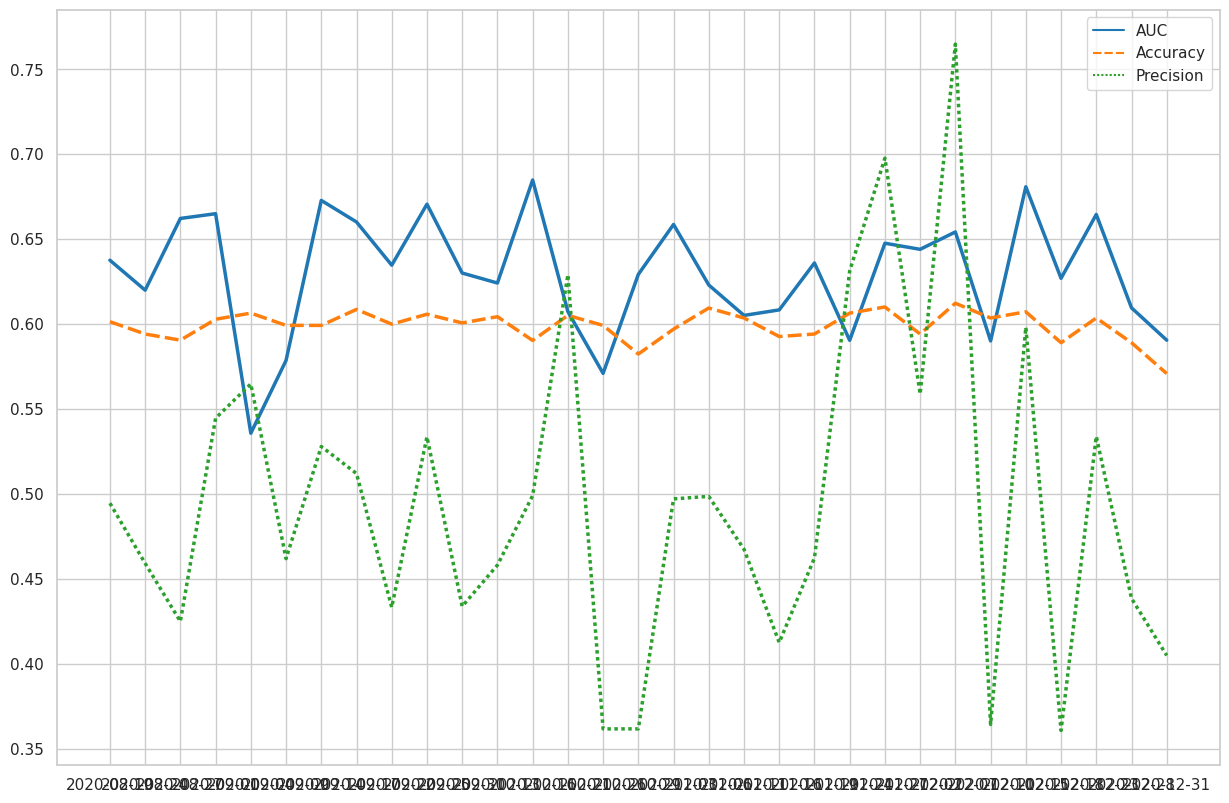

In [ ]:
fig = plt.figure(figsize= (15,10))
sns.set(style="whitegrid")
xs_date = test_date_list[: -1]

data1 = pd.DataFrame(test_sample_roc_auc, xs_date, columns={'AUC'})
data2 = pd.DataFrame(test_sample_accuracy, xs_date, columns={'Accuracy'})
data3 = pd.DataFrame(test_sample_precision, xs_date, columns={'Precision'})
data = pd.concat([data1, data2, data3],sort=False)
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

In [ ]:
# 评估
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score, f1_score

print(classification_report(y_test_all, y_pred_all))

conf_mat = confusion_matrix(y_test_all, y_pred_all)
print(conf_mat)

print("F1 score (weighted)", f1_score(y_test_all, y_pred_all, labels=None,average='weighted', sample_weight=None))
print("F1 score (macro)", f1_score(y_test_all, y_pred_all, labels=None, average='macro', sample_weight=None))
print("F1 score (micro)", f1_score(y_test_all, y_pred_all, labels=None, average='micro', sample_weight=None))  

# https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-s-kappa --> supports multiclass; ref: https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english
print("cohen's Kappa", cohen_kappa_score(y_test_all, y_pred_all))

recall = []
for i, row in enumerate(conf_mat):
    recall.append(np.round(row[i]/np.sum(row), 2))
    print("Recall of class {} = {}".format(i, recall[i]))
    
print("Recall avg", sum(recall)/len(recall))

              precision    recall  f1-score   support

           0       0.32      0.02      0.03      1718
           1       0.61      0.98      0.75      5118
           2       0.35      0.02      0.05      1687

    accuracy                           0.60      8523
   macro avg       0.42      0.34      0.27      8523
weighted avg       0.50      0.60      0.47      8523

[[  26 1661   31]
 [  33 5040   45]
 [  23 1623   41]]
F1 score (weighted) 0.4651228216501157
F1 score (macro) 0.27474394793543727
F1 score (micro) 0.5992021588642497
cohen's Kappa 0.019745906557756432
Recall of class 0 = 0.02
Recall of class 1 = 0.98
Recall of class 2 = 0.02
Recall avg 0.34


## 投资组合分析

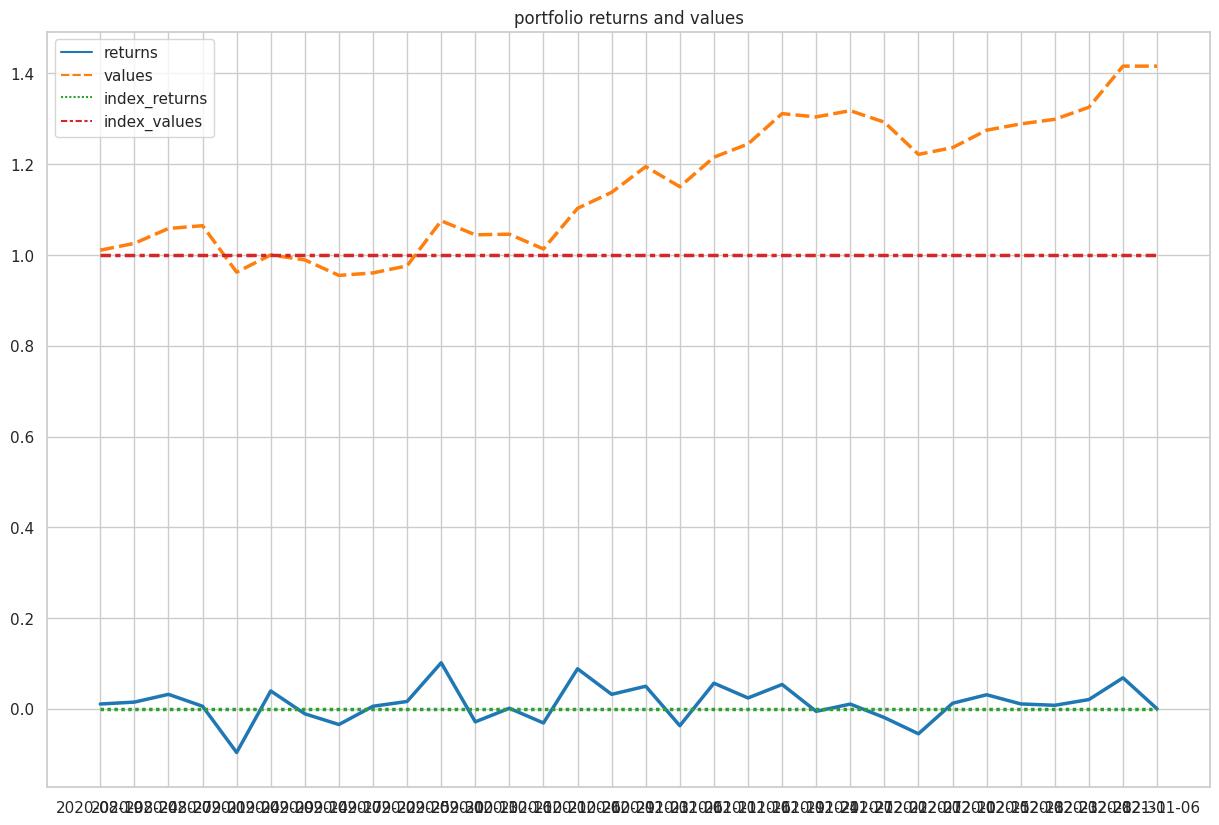

In [ ]:
fig = plt.figure(figsize= (15,10))
plt.title("portfolio returns and values")
sns.set(style="whitegrid")
sns.lineplot(data=index_portfolio, palette="tab10", linewidth=2.5)